In [124]:
import torch
import pickle as pickle
from transformers import Trainer, TrainingArguments, AutoTokenizer
import pandas as pd
from data.dataset import RE_Dataset
from utils.utils import set_seed
from model.model import load_model
from utils.metrics import compute_metrics
import matplotlib.pyplot as plt


### 1. valid.csv 파일 -> inference 진행 후, 정답 비교

In [106]:
# valid dataset inference 진행 후, csv 파일 저장
valid_df = pd.read_csv('./dataset/train/valid_split_v1.csv')
valid_df['label'] = 100
valid_df.head()
valid_df.to_csv('./dataset/test/valid_data.csv', index=False)

In [118]:
# csv 불러오기
my_df = pd.read_csv("./prediction/submission-valid-roberta-base-none-256-0.05-4e-5-earlystopping.csv") # 내 output.csv
answer_df = pd.read_csv('./dataset/train/valid_split_v1.csv')

# column 이름 변경하기
answer_df.rename(columns = {'label':'answer_label'}, inplace = True)
my_df.rename(columns = {'pred_label':'my_label', 'probs':'my_probs'}, inplace = True)

# 파일 합치기
df = pd.concat([answer_df, my_df], axis=1)
new_order = ['id', 'answer_label', 'my_label', 'sentence', 'subject_entity', 'object_entity', 'source', 'my_probs']
df = df[new_order]

# subject, object word 추출
subject_entity = []
object_entity = []
for i,j in zip(df['subject_entity'], df['object_entity']):
    subject_dict, object_dict = eval(i), eval(j)

    subject_entity.append(subject_dict['word'])
    object_entity.append(object_dict['word'])
df['subject_entity'] = subject_entity
df['object_entity'] = object_entity

# 틀린 행 추출
diff = df['my_label'] != df['answer_label']
result = df[diff]
result

,id,id,answer_label,my_label,sentence,subject_entity,object_entity,source,my_probs
10,414,414,no_relation,org:member_of,경상북도교육청과 경북사회복지공동모금회가 공동으로 진행하는 이번 캠페인은 코로나-19...,김천교육지원청,경상북도교육청,wikitree,"[0.0016183190746232867, 6.35016622254625e-05, ..."
28,32078,32078,no_relation,per:title,그러나 한인 독립운동가들 중에서도 안창호를 중심으로 한 국민회와 이승만을 중심으로 ...,서재필,독립운동가,wikipedia,"[4.102703314856626e-05, 3.229204230592586e-05,..."
29,940,940,no_relation,per:children,노스가 국왕 조지 3세와 많이 닮았기 때문에 동시대의 사람들은 프레더릭 왕자가 노스...,조지 3세,프레더릭,wikipedia,"[0.00015424523735418916, 0.0002038609673036262..."
34,13001,13001,no_relation,org:top_members/employees,1943년 샤를 드 골에게 간 드타시니는 프랑스 해방군에서 1945년까지 복무하였고...,자유 프랑스,샤를 드 골,wikipedia,"[4.679316043620929e-05, 0.9991446733474731, 5...."
42,29917,29917,per:title,no_relation,연해주 지역의 독립운동가들은 문창범 등이 미주 지역의 안창호와 연락하는 등의 노력을...,손병희,독립운동가,wikipedia,"[0.8873335123062134, 0.00037502648774534464, 0..."
...,...,...,...,...,...,...,...,...,...
3205,21034,21034,no_relation,per:employee_of,코로나19 민생센터는 윤소하 의원실과 이보라미 정의당 전남도당 위원장(현 전남도의원...,윤소하,정의당,wikitree,"[0.0013049731496721506, 4.432748755789362e-05,..."
3211,16122,16122,org:member_of,no_relation,그는 “지난해 실적을 살펴보면 아시아나항공과 자회사 LCC 간의 차이가 커졌다. 에...,에어부산,아시아나항공,wikitree,"[0.9987713694572449, 0.00013903550279792398, 6..."
3230,30730,30730,org:member_of,no_relation,현재 신한은행으로 합병된 조흥은행은 민족자본은행 100년사에 대해 강한 자부심을 보...,조흥은행,신한은행,wikipedia,"[0.7882893085479736, 0.00027869828045368195, 0..."
3242,24107,24107,per:parents,no_relation,그러나 인종이 경원대군에게 선위하고 경원대군이 12세의 나이로 즉위하여 문정왕후가 ...,경원대군,문정왕후,wikipedia,"[0.9878970384597778, 0.0003032169188372791, 6...."


In [130]:
print(f'전체 valid 개수: {len(valid_df)}')
print(f'답이 틀린 개수: {len(result)}')

전체 valid 개수: 3247
답이 틀린 개수: 550


카테고리 별 개수:
no_relation                            230
per:employee_of                         53
org:member_of                           48
org:members                             24
per:origin                              23
org:place_of_headquarters               22
org:alternate_names                     21
per:colleagues                          20
per:place_of_residence                  14
per:title                               10
per:alternate_names                     10
org:product                              9
org:top_members/employees                8
per:spouse                               8
per:children                             8
per:place_of_birth                       7
org:founded                              7
per:other_family                         6
per:parents                              5
org:founded_by                           4
per:siblings                             3
org:dissolved                            3
per:product                              3


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/

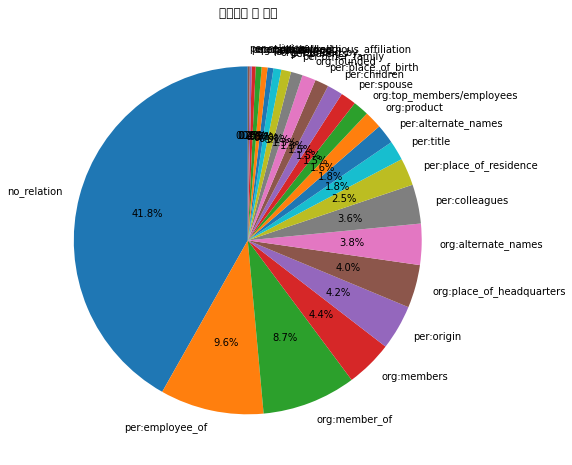

In [132]:
# 카테고리 별 개수 구하기
category_counts = result['answer_label'].value_counts()

# 카테고리 별 개수 출력
print("카테고리 별 개수:")
print(category_counts)

# 파이 차트로 시각화
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('카테고리 별 개수')
plt.show()

정답이 no_relation일 때, 잘못 예측한 것에 대한 분석

카테고리 별 개수:
per:employee_of                        38
org:top_members/employees              32
org:member_of                          26
org:place_of_headquarters              21
per:origin                             20
per:title                              19
org:members                            10
per:colleagues                         10
org:product                             7
per:spouse                              6
per:other_family                        5
per:date_of_death                       4
org:founded                             4
per:place_of_residence                  4
per:parents                             4
per:date_of_birth                       3
org:dissolved                           3
per:place_of_birth                      2
org:alternate_names                     2
per:religion                            2
org:political/religious_affiliation     2
per:alternate_names                     1
org:number_of_employees/members         1
per:schools_attended   

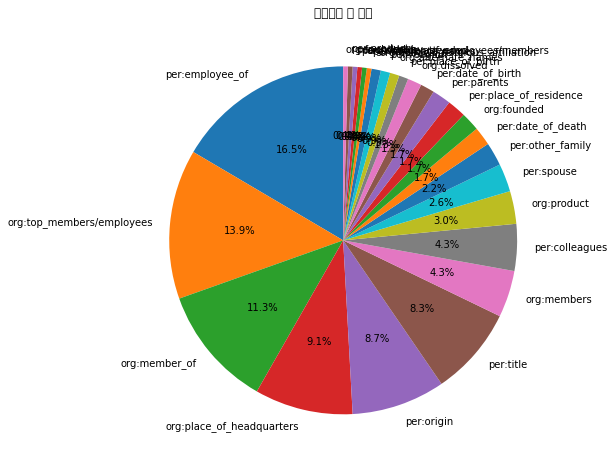

In [136]:
no_relation_df = result[result['answer_label'] == 'no_relation']

# 카테고리 별 개수 구하기
category_counts = no_relation_df['my_label'].value_counts()

# 카테고리 별 개수 출력
print("카테고리 별 개수:")
print(category_counts)

# 파이 차트로 시각화
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('카테고리 별 개수')
plt.show()

### 2. 다른 사람 ouput.csv 파일과 내 output.csv 파일 비교

label이 다른 행들을 출력합니다.

In [104]:
output_df = pd.read_csv("./output.csv") # 다른 사람 output.csv
my_df = pd.read_csv("./prediction/submission-roberta-large-focal-64-0.05-2e-5.csv") # 내 output.csv
test_data = pd.read_csv('./dataset/test/test_data.csv') # test.csv 파일 불러오기

test_data = test_data[['sentence', 'subject_entity', 'object_entity', 'source']]
my_df.rename(columns = {'pred_label':'my_label', 'probs':'my_probs'}, inplace = True)
output_df.rename(columns = {'pred_label':'output_label', 'probs':'output_probs'}, inplace = True)

my_df = my_df.drop(columns='id')

df = pd.concat([test_data, my_df, output_df], axis=1)
new_order = ['id', 'output_label', 'my_label', 'sentence', 'subject_entity', 'object_entity', 'source', 'my_probs', 'output_probs']
df = df[new_order]
# df.head()

subject_entity = []
object_entity = []
for i,j in zip(df['subject_entity'], df['object_entity']):
    subject_dict, object_dict = eval(i), eval(j)

    subject_entity.append(subject_dict['word'])
    object_entity.append(object_dict['word'])
df['subject_entity'] = subject_entity
df['object_entity'] = object_entity

diff = df['my_label'] != df['output_label']
result = df[diff]
result

,id,output_label,my_label,sentence,subject_entity,object_entity,source,my_probs,output_probs
4,4,no_relation,org:top_members/employees,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지...",민주당,권영진,wikitree,"[0.403094083070755, 0.5861749649047852, 0.0018...","[0.9932832717895508, 0.0065030427649617195, 1...."
17,17,no_relation,per:date_of_death,무령왕의 왕위를 계승한 성왕(재위 523 ~ 554년)도 일본과의 우호관계를 이어갔다.,무령왕,554년,wikipedia,"[0.09277790039777756, 0.001237761927768588, 0....","[0.9998606443405151, 6.710502475471003e-06, 5...."
22,22,org:top_members/employees,no_relation,"이번 행사에 참여한 광주여대 재학생은 ""평소 관심이 있던 마케팅·브랜드 분야의 현직...",광주여대,재학생,wikitree,"[0.5684049129486084, 0.2886436879634857, 0.089...","[0.2722696363925934, 0.7256110310554504, 0.000..."
24,24,no_relation,org:member_of,이날 협약식에는 경남대 최호성 대외부총장과 거제 라마다 스위츠 거제호텔 정행철 대표...,라마다 스위츠 거제호텔,경남대 관광학부,wikitree,"[0.44807958602905273, 0.00044993110350333154, ...","[0.9997945427894592, 3.2162713523575803e-06, 3..."
25,25,no_relation,org:place_of_headquarters,이에 따라 제주특별자치도청은 한국정보화진흥원을 제주로 이전하는 방안과 대구로의 이전...,한국정보화진흥원,대구,wikipedia,"[0.32582637667655945, 0.00025721886777319014, ...","[0.999869704246521, 1.7758090962161077e-06, 4...."
...,...,...,...,...,...,...,...,...,...
7737,7737,org:top_members/employees,no_relation,"잉글랜드 성공회의 성인이기도 하며, 성공회에서는 8월 13일을 나이팅게일의 축일로 ...",성공회,성인,wikipedia,"[0.4858751893043518, 0.46243923902511597, 0.02...","[0.131730318069458, 0.858849823474884, 0.00226..."
7743,7743,no_relation,org:place_of_headquarters,올리브영은 1일 오전 서울시 마포구에 위치한 서울시립청소녀건강센터에 여성 위생용품이...,올리브영,서울시,wikitree,"[0.30962058901786804, 0.0004334517288953066, 0...","[0.9989940524101257, 8.393167263420764e-06, 3...."
7744,7744,per:employee_of,no_relation,앞서 슬리피는 TS 직원들이 카니발을 사적으로 사용하는 바람에 소속사 연예인들은 S...,슬리피,연예인,wikitree,"[0.6334252953529358, 0.002155416877940297, 0.0...","[0.004077299498021603, 0.00012778023665305227,..."
7749,7749,no_relation,org:top_members/employees,육군 예비역이 된 성규는 바쁘게 활동을 재개한다.,육군,예비역,wikitree,"[0.47486984729766846, 0.5085529685020447, 0.00...","[0.8999319672584534, 0.0741695910692215, 0.012..."
